## 데이터 처리 -> 주가 데이터 활용


In [37]:
!pip install finance-datareader 
!pip install beatifulsoup4

ERROR: Could not find a version that satisfies the requirement beatifulsoup4 (from versions: none)
ERROR: No matching distribution found for beatifulsoup4


In [38]:
 pip install beautifulsoup4 

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


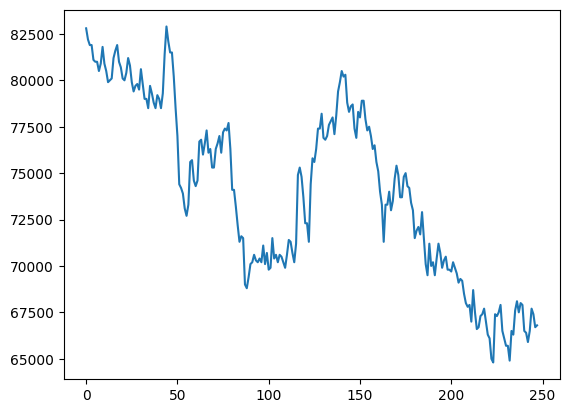

In [40]:
import FinanceDataReader as fdr
df = fdr.DataReader( '005930', '2021-06-03', '2022-06-03')
data = df['Close'].values
from matplotlib import pyplot as plt
plt.plot(data)

## 시게열 전처리 클래스, 시게열 데이터 로더 클래스 정의 

In [41]:
import numpy as np
class TimeSeriesData:

    def __init__(self, data, window_length, prediction_length):
        self.data = data
        self.window_length = window_length
        self.prediction_length = prediction_length
        self.X = []
        self.y = []
        self.create_dataset()

    def create_dataset(self):
        for i in range(len(self.data) - self.window_length - self.prediction_length):
            self.X.append(self.data[i:i+self.window_length])
            self.y.append(self.data[i+self.window_length:i+self.window_length+self.prediction_length])
        self.X = np.array(self.X)# (N, window_length) 30일간의 데이터rk 가총 100개의 데이터가 있다면 70개의 데이터가 생성 0~29, 1~30, 2~31, ... 69~98
        self.y = np.array(self.y)# (N, prediction_length) 7일간의 데이터가 총 100개의 데이터가 있다면 70개의 데이터가 생성 30~37, 31~38, 32~39, ... 99~106
    
    def minmax_scale(self):
        self.X = (self.X - np.min(self.X)) / (np.max(self.X) - np.min(self.X))
        self.y = (self.y - np.min(self.y)) / (np.max(self.y) - np.min(self.y))

    def get_data(self):
        self.minmax_scale()
        return self.X, self.y   






from torch.utils.data import Dataset
class TImeSeriesLoader(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

from torch.utils.data import DataLoader
import torch

## 모델 정의

In [42]:

class LSTM(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size, num_layers, output_size,device):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = torch.nn.Linear(hidden_size, output_size)
            self.device = device
    
        def forward(self, x):
            x=x.unsqueeze(2) # (N, window_length) -> (N, window_length, 1) 왜냐하면 lstm은 3차원 데이터를 받기 때문 만약 다변량 시게열이다 -. (N, window_length, feature_size)
            h0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
            c0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
            out, (hn, cn) = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
            out = self.fc(out[:, -1, :]) # (N, seq_length, hidden_size) -> (N, output_size)
            return out
        




## trainer 정의

In [48]:
class Trainer:

    def __init__(self, model, dataloader, optimizer, criterion, device):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train(self, epochs):
        #self.model.train()
        for epoch in range(epochs):
            for i, (X, y) in enumerate(self.dataloader):
                X = X.to(self.device).float()
                y = y.to(self.device).float()
                outputs = self.model(X)
                loss = self.criterion(outputs, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(self.dataloader)}], Loss: {loss.item():.4f}')
        print('Finished Training')
    

In [49]:
window_length = 30 # 30일간의 데이터로부터 다음 7일을 예측
prediction_length = 7 # 7일을 예측
tsd = TimeSeriesData(data, window_length, prediction_length)
X, y = tsd.get_data()
dataset = TImeSeriesLoader(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(1, 128, 1, 7, device).to(device) # input_size=1, hidden_size=128(lstm의 hidden dim), num_layers=1(한개의 lstm layer), output_size=7(7일을 예측하기 때문에 output_size=7)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, dataloader, optimizer, criterion, device)
trainer.train(100)


Epoch [1/100], Step [1/4], Loss: 0.2659
Epoch [1/100], Step [2/4], Loss: 0.1676
Epoch [1/100], Step [3/4], Loss: 0.3639
Epoch [1/100], Step [4/4], Loss: 0.1657
Epoch [2/100], Step [1/4], Loss: 0.1916
Epoch [2/100], Step [2/4], Loss: 0.1737
Epoch [2/100], Step [3/4], Loss: 0.1699
Epoch [2/100], Step [4/4], Loss: 0.1580
Epoch [3/100], Step [1/4], Loss: 0.1377
Epoch [3/100], Step [2/4], Loss: 0.0805
Epoch [3/100], Step [3/4], Loss: 0.0591
Epoch [3/100], Step [4/4], Loss: 0.0723
Epoch [4/100], Step [1/4], Loss: 0.0551
Epoch [4/100], Step [2/4], Loss: 0.0491
Epoch [4/100], Step [3/4], Loss: 0.0597
Epoch [4/100], Step [4/4], Loss: 0.0419
Epoch [5/100], Step [1/4], Loss: 0.0552
Epoch [5/100], Step [2/4], Loss: 0.0507
Epoch [5/100], Step [3/4], Loss: 0.0403
Epoch [5/100], Step [4/4], Loss: 0.0431
Epoch [6/100], Step [1/4], Loss: 0.0430
Epoch [6/100], Step [2/4], Loss: 0.0480
Epoch [6/100], Step [3/4], Loss: 0.0441
Epoch [6/100], Step [4/4], Loss: 0.0479
Epoch [7/100], Step [1/4], Loss: 0.0355
